# Анализ данных клавиатурного почерка

Импортируем библиотеки:

In [80]:
from operator import itemgetter
from os import listdir as ls
import json
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

Поскольку в данных содержится keycode клавиши, нужно разделить keycodes на категории. Выделим:
- 5 категорий клавиш печатных символов по расположению их на клавиатуре - 4 категории букв слева направо и пробел

- Shift

- CTRL, ALT, CMD для определения способа переключения раскладки

- Backspace для определения опечаток

Ниже определены также вспомогательные функции.

In [5]:
groups = [[49, 50, 81, 87, 65, 83, 90, 88],
         [51, 52, 53, 69, 82, 84, 68, 70, 71, 67, 86, 66],
         [54, 55, 56, 89, 85, 73, 72, 74, 75, 78, 77, 188],
         [57, 48, 173, 61, 79, 80, 219, 221, 76, 59, 222, 13, 190, 191],
         [32]]
key_groups = {item: j+1 for j in range(len(groups)) for item in groups[j]}
print(key_groups)

LETTER_KEYS = list(range(48, 58)) + list(range(65, 91)) + [192, 173, 61, 219, 220, 221, 59, 222, 13, 188, 190, 191, 32]
SHIFT_KEY = 16
CTRL_KEY = 17
ALT_KEYS = [18, 225]
CMD_KEYS = [91, 93]
CAPS_KEY = 20
BACKSPACE_KEY = 8
DEL_KEY = 46
ARROW_KEYS = list(range(37, 41))

def get_key_group(key):
    """
    input: int|Series, output: int
    Возвращает номер группы, к которой принадлежит клавиша. Слева направо - 1-4, пробел - 5, непечатные символы - 0
    """
    if isinstance(key, int):
        return key_groups.get(key, 0)
    elif isinstance(key, pd.Series):
        return key_groups.get(key['key'], 0)

def get_groups_number():
    """
    Возвращает количество созданных групп. Оно задается списком groups.
    """
    return len(groups)

def count_backspaced_symbols(time):
    """
    Определяет, сколько символов назад нужно отсчитать до опечатки. Зависит от продолжительности удержания backspace.
    """
    if isinstance(time, int) or isinstance(time, float):
        return (1 + int((time - 1000) / 250)) if time > 1000 else 1
    elif isinstance(time, pd.Series):
        return (1 + int((time['duration'] - 1000) / 250)) if time['duration'] > 1000 else 1

{49: 1, 50: 1, 81: 1, 87: 1, 65: 1, 83: 1, 90: 1, 88: 1, 51: 2, 52: 2, 53: 2, 69: 2, 82: 2, 84: 2, 68: 2, 70: 2, 71: 2, 67: 2, 86: 2, 66: 2, 54: 3, 55: 3, 56: 3, 89: 3, 85: 3, 73: 3, 72: 3, 74: 3, 75: 3, 78: 3, 77: 3, 188: 3, 57: 4, 48: 4, 173: 4, 61: 4, 79: 4, 80: 4, 219: 4, 221: 4, 76: 4, 59: 4, 222: 4, 13: 4, 190: 4, 191: 4, 32: 5}


### Класс для обработки данных
Создадим класс Document, который будем использовать для преобразования сырых данных из JSON в признаки.
Класс умеет выделять следующие признаки:
- Среднюю и медианную продолжительность зажатия клавиш по группам;
- Средний и медианный интервал перед нажатием клавиши по группам;
- Относительное количество опечаток по группам, а также левой руки к правой и центра клавиатуры к краю;
- Способ переключения раскладки клавиатуры;
- Доля ошибочно нажатых шифтов, их средняя продолжительность нажатия;
- Среднее и медианное время от зажатия шифта до зажатия буквы и от зажатия буквы до отпускания шифта по группам;
- Количество слов, запоминаемых за раз человеком при перепечатывании текста.

In [55]:
class Document:
    def __init__(self, filename=None, data=None):
        """
        Конструктор: принимает либо файл, либо готовые данные.
        """
        if filename is not None:
            with open(filename, 'r') as file:
                self.raw_data = json.load(file)['data']
            self.transform_raw_data()
        elif data is not None:
            self.data = data.reset_index(drop=True)
        else:
            raise ValueError("filename or data should be provided")
        self.features = {}
    
    def transform_raw_data(self):
        """
        Преобразование из JSON в Dataframe с колонками: keycode клавиши, время нажатия, время отпускания,
        индикатор зажатия шифта в момент нажатия на клавишу (по умолчанию False, выставляется в transform_data)
        """
        self.raw_data = pd.DataFrame(self.raw_data).sort_values(by=['key', 'timestamp'], ascending=[1, 1])
        data = pd.DataFrame(columns=['key', 'down', 'up', 'shift'])
        for _, row in self.raw_data.iterrows():
            if row['press'] == 'down':
                data.at[data.shape[0], ['key', 'down', 'shift']] = [row['key'], row['timestamp'], False]
            elif row['press'] == 'up':
                data.at[data.shape[0]-1, 'up'] = row['timestamp']
        self.data = data[data['key']!=0].dropna().infer_objects()
        
    def transform_data(self):
        """
        Подсчет дополнительных данных для выделения признаков
        """
        self.data[['up', 'down']] -= self.data['down'].min()
        self.sort_data()
        shifts = self.data[self.data['key']==SHIFT_KEY].sort_values(by='down')
        for i, row in self.data.iterrows():
            # Разбить клавиши на группы
            self.data.loc[i, 'key_group'] = get_key_group(row['key'])
            # Добавить признак shift
            if not shifts.query('down <= %d and up >= %d' % ((row['down'],)*2)).empty:
                self.data.loc[i, 'shift'] = True
            # Добавить продолжительность зажатия
            self.data.loc[i, 'duration'] = row['up'] - row['down']
            # Добавить интервал от предыдущего отпуска клавиши
            self.data.loc[i, 'interval'] = row['down'] - self.data.iloc[i-1]['up']
            # Добавить предыдущую клавишу
            self.data.loc[i, 'prev_key'] = self.data.iloc[i-1]['key']
        self.data.loc[0, 'interval'] = np.nan
        self.data.loc[0, 'prev_key'] = np.nan
        self.set_key_data()
        self.set_typos()
        self.set_shifts()
        self.set_mistaken_shifts()
        
    def sort_data(self, by='down'):
        """
        Сортировка данных, по умолчанию - по времени зажатия клавиши.
        """
        self.data = self.data.sort_values(by=by).reset_index(drop=True)

    def set_key_data(self):
        """
        Выделить из всех нажатий нажатия печатных символов.
        """
        self.key_data = self.data[self.data['key_group']!=0]
        
    def set_shifts(self):
        """
        Выделить из всех нажатий нажатия на шифты.
        """
        self.shifts = self.data[self.data['key']==SHIFT_KEY].sort_values(by='down').query('duration > 0')
        
    def set_mistaken_shifts(self):
        """
        Выделить из всех шифтов ошибочно нажатые (когда был зажат только шифт, без смысловых клавиш)
        """
        mistaken_shifts_index = self.shifts[self.shifts['prev_key']==SHIFT_KEY].index - 1
        mistaken_shifts_index.append(self.key_data.query('shift == False and prev_key == %d' % SHIFT_KEY).index - 1)
        self.mistaken_shifts = self.shifts.loc[mistaken_shifts_index]
        
    def set_typos(self):
        """
        Выделить опечатки
        """
        backspaces = self.data[self.data['key'] == BACKSPACE_KEY].sort_index(ascending=False)
        backspaces['n_erased'] = backspaces['duration'].apply(count_backspaced_symbols)
        drop = []
        for i, bs in backspaces.iterrows():
            if i-1 in backspaces.index:
                backspaces.loc[i-1, 'n_erased'] += bs['n_erased']
                drop.append(i)
        backspaces = backspaces.drop(drop)
        typos_indexes = self.key_data.index.searchsorted(backspaces.index-backspaces['n_erased'])
        self.typos = self.key_data.loc[typos_indexes].dropna()
        
            
    def count_avg_duration(self, quantile=.95, verbose=True, plot=True):
        """
        Подсчет средней и медианной продолжительности зажатия клавиш
        """
        self.duration_data = self.key_data.query('duration < duration.quantile(%f)' % quantile).reset_index(drop=True)
        avg_duration = self.duration_data.groupby('key_group')['duration'].mean()
        med_duration = self.duration_data.groupby('key_group')['duration'].median()
        for k in avg_duration.keys():
            self.features['avg_duration%d' % k] = avg_duration[k]
        for k in med_duration.keys():
            self.features['med_duration%d' % k] = med_duration[k]
        # output
        if plot:
            self.plot(which='duration')
        if verbose:
            print('Под %f-м квантилем %d значений.' % (quantile, len(self.duration_data)))
            print("Средняя продолжительность удержания клавиш:\n", avg_duration)
            print("Медианная продолжительность удержания клавиш:\n", med_duration)

    def count_avg_interval(self, quantile=.95, verbose=True, plot=True):
        """
        Подсчет среднего и медианного интервала перед клавишами
        """
        self.interval_data = self.key_data.query('interval.quantile(%f) < interval < interval.quantile(%f)' % \
                                                    ((1-quantile)/2, quantile+(1-quantile)/2)).reset_index(drop=True)
        avg_interval = self.interval_data.groupby('key_group')['duration'].mean()
        med_interval = self.interval_data.groupby('key_group')['interval'].median()
        for k in avg_interval.keys():
            self.features['avg_interval%d' % k] = avg_interval[k]
        for k in med_interval.keys():
            self.features['med_interval%d' % k] = med_interval[k]
        # output
        if plot:
            self.plot(which='interval')
        if verbose:
            print('Под %f-м квантилем %d значений.' % (quantile, len(self.interval_data)))
            print("Средняя продолжительность интервала между нажатиями:\n", avg_interval)
            print("Медианная продолжительность интервала между нажатиями:\n", med_interval)
            
    def count_typos(self, verbose=True):
        """
        Подсчет количества опечаток
        """
        typos = self.typos.groupby('key_group').count().iloc[:, 0]
        presses = self.key_data.groupby('key_group').count().iloc[:, 0]
        typos_presses_relation = typos / presses
        lr_typos_relation = typos[[1, 2]].sum() / typos[[3, 4]].sum()
        ce_typos_relation = typos[[2, 3]].sum() / typos[[1, 4]].sum()
        for k in typos_presses_relation.keys():
            self.features['typos_per_presses%d' % k] = typos_presses_relation[k]
        self.features['typos_left_right'] = lr_typos_relation
        self.features['typos_center_edge'] = ce_typos_relation
        if verbose:
            print("Относительное количество опечаток:\n", typos_presses_relation)
            print('Слева/справа клавиатуры: ', lr_typos_relation)
            print('В центре/скраю клавиатуры: ', ce_typos_relation)
            
    def count_lang_changing(self, verbose=True):
        """
        Определение способа изменения раскладки клавиатуры
        """
        ctrls = self.data[self.data['key'] == CTRL_KEY]
        ctrl_spaces = self.data.loc[ctrls.index+1].query('key == 32').iloc[:, 0].count()
        ctrl_shifts = ctrls.iloc[:, 0].count() - ctrl_spaces
        alts = self.data[self.data['key'] == ALT_KEYS[0]].iloc[:, 0].count()
        cmds = self.data[self.data['key'].isin(CMD_KEYS)].iloc[:, 0].count()
        labels = {'ctrl_space': ctrl_spaces, 'ctrl_shift': ctrl_shifts, 'alt': alts, 'cmd': cmds}
        m = max(labels.items(), key=itemgetter(1))[0]
        self.features['lang'] = m if m != 0 else np.nan
        if verbose:
            print('Переключение раскладки клавиатуры:', m if m != 0 else 'не совершалось.')
            
    def count_shift_mistakes(self, verbose=True):
        """
        Подсчет ошибочно нажатых шифтов
        """
        mistakes_avg_duration = self.mistaken_shifts['duration'].mean()
        mistakes_rate = self.mistaken_shifts.iloc[:, 0].count() / self.shifts.iloc[:, 0].count()
        self.features['shift_mistakes'] = mistakes_rate
        self.features['mistaken_shift_duration'] = mistakes_avg_duration
        if verbose:
            print('Доля ошибочно нажатых шифтов: ', mistakes_rate)
            print('Средняя продолжительность ошибочно нажатого шифта: ', mistakes_avg_duration)
            
    def count_shift_distance(self, plot=True, verbose=True):
        """
        Подсчет интервалов внутри шифтов
        """
        shifts = self.shifts.drop(self.mistaken_shifts.index)
        shifted = self.key_data[self.key_data['shift']==True]
        
        self.first_shifted = shifted[shifted['prev_key'] == SHIFT_KEY]
        self.first_shifted['down_interval'] = self.first_shifted['down'] - \
                                shifts.loc[self.first_shifted.index-1].set_index(self.first_shifted.index)['down']
        first_interval_median = self.first_shifted.groupby('key_group')['down_interval'].median()
        first_interval_mean = self.first_shifted.groupby('key_group')['down_interval'].mean()
        
        iis = shifted['down'].searchsorted(self.shifts['up'], side='right') - 1 # номера последних по времени
        self.last_shifted = shifted.iloc[iis]                                   # нажатия клавиш под каждым шифтом
        up_intervals = self.shifts.set_index(self.last_shifted.index)['up'] - self.last_shifted['down']
        up_intervals = up_intervals.groupby(level=0).first()
        self.last_shifted['up_interval'] = up_intervals
        last_interval_median = self.last_shifted.groupby('key_group')['up_interval'].median()
        last_interval_mean = self.last_shifted.groupby('key_group')['up_interval'].mean()
        
        for k in first_interval_median.keys():
            self.features['shift_first_interval_med%d' % k] = first_interval_median[k]
        for k in last_interval_median.keys():
            self.features['shift_last_interval_med%d' % k] = last_interval_median[k]
        for k in first_interval_mean.keys():
            self.features['shift_first_interval_avg%d' % k] = first_interval_mean[k]
        for k in last_interval_mean.keys():
            self.features['shift_last_interval_avg%d' % k] = last_interval_mean[k]
            
        if plot:
            self.plot(which='shift')
        if verbose:
            print('Медианный интервал от зажатия шифта до нажатия клавиши:\n', first_interval_median)
            print('Медианный интервал от зажатия клавиши до отпуска шифта:\n', last_interval_median)
            print('Средний интервал от зажатия шифта до нажатия клавиши:\n', first_interval_mean)
            print('Средний интервал от зажатия клавиши до отпуска шифта:\n', last_interval_mean)

    def count_words_in_memory(self, plot=True, verbose=True):
        """
        Подсчет слов, запоминаемых пользователем за раз
        """
        # интервалы перед пробелом:
        self.space_intervals = a.key_data.query('key == 32').reset_index(drop=True)['interval']
        self.space_intervals += a.key_data.query('prev_key == 32').reset_index(drop=True)['interval'] # после пробела
        all_spaces_count = self.data[self.data['key'] == 32].iloc[:, 0].count()
        long_spaces_count = self.space_intervals[self.space_intervals>self.key_data['interval'].quantile(.9)].count()
        words_in_memory = all_spaces_count / long_spaces_count
        self.features['words_in_memory'] = words_in_memory
        if verbose:
            print('Человек запоминает в среднем слов: ', words_in_memory)
        if plot:
            self.plot(which='spaces')
    
    def plot(self, which='all', xsize=11, ysize=7, lmplot=True, density=True):
        """
        Построить графики
        which=[duration, interval, shift, shift_before, shift_after, spaces, all], str
        """
        plt.rcParams['figure.figsize'] = (xsize, ysize)
        if 'duration' in which or 'all' in which:
            if 'duration_data' not in vars(self):
                self.count_avg_duration(verbose=False, plot=False)
            if lmplot:
                (sns
                    .lmplot(x='down',
                            y='duration',
                            hue='key_group',
                            data=self.duration_data,
                            size=ysize,
                            aspect=xsize/ysize)
                    .set(xlabel='Время, мс',
                         ylabel='Продолжительность нажатия, мс',
                         title="Продолжительность зажатия клавиш"))
            if density:
                plot = self.duration_data.groupby('key_group')['duration'].plot.hist(
                    legend=True,
                    title="Плотность распределения времени зажатия по группам",
                    ax=plt.figure().add_subplot())
                plot.iloc[0].set_xlabel("Продолжительность нажатия, мс")
                plot.iloc[0].set_ylabel("Плотность распределения")
        if 'interval' in which or 'all' in which:
            if 'interval_data' not in vars(self):
                self.count_avg_interval(verbose=False, plot=False)
            if lmplot:
                (sns
                    .lmplot(x='down',
                            y='interval',
                            hue='key_group',
                            data=self.interval_data,
                            size=ysize,
                            aspect=xsize/ysize)
                    .set(xlabel='Время, мс',
                         ylabel='Интервал, мс',
                         title="Интервалы перед нажатием клавиш"))
            if density:
                plot = self.interval_data.groupby('key_group')['interval'].plot.hist(
                    legend=True,
                    title="Плотность распределения интервалов по группам",
                    ax=plt.figure().add_subplot())
                plot.iloc[0].set_xlabel("Интервал, мс")
                plot.iloc[0].set_ylabel("Плотность распределения")
        if 'shift' in which or 'shift_before' in which or 'all' in which:
            if 'first_shifted' not in vars(self):
                self.count_shift_distance(verbose=False, plot=False)
            if lmplot:
                (sns
                    .lmplot(x='down',
                            y='down_interval',
                            hue='key_group',
                            data=self.first_shifted,
                            size=ysize,
                            aspect=xsize/ysize)
                    .set(xlabel='Время, мс',
                         ylabel='Интервал shift->клавиша, мс',
                         title="Продолжительность интервала от зажатия shift до зажатия клавиши"))
            if density:
                plot = self.first_shifted.groupby('key_group')['down_interval'].plot.hist(
                    legend=True,
                    title="Плотность распределения интервала от зажатия shift до зажатия клавиши по группам",
                    ax=plt.figure().add_subplot())
                plot.iloc[0].set_xlabel("Продолжительность интервала, мс")
                plot.iloc[0].set_ylabel("Плотность распределения")
        if 'shift' in which or 'shift_after' in which or 'all' in which:
            if 'last_shifted' not in vars(self):
                self.count_shift_distance(verbose=False, plot=False)
            if lmplot:
                (sns
                    .lmplot(x='down',
                            y='up_interval',
                            hue='key_group',
                            data=self.last_shifted,
                            size=ysize,
                            aspect=xsize/ysize)
                    .set(xlabel='Время, мс',
                         ylabel='Интервал клавиша->shift, мс',
                         title="Продолжительность интервала от зажатия клавиши до отпускания shift"))
            if density:
                plot = self.last_shifted.groupby('key_group')['up_interval'].plot.hist(
                    legend=True,
                    title="Плотность распределения интервала от зажатия клавиши до отпускания shift по группам",
                    ax=plt.figure().add_subplot())
                plot.iloc[0].set_xlabel("Продолжительность интервала, мс")
                plot.iloc[0].set_ylabel("Плотность распределения")
        if 'spaces' in which or 'all' in which:
            if 'space_intervals' not in vars(self):
                self.count_words_in_memory(verbose=False, plot=False)
            if lmplot:
                plot = self.space_intervals.plot(title="Продолжительность интервалов между словами",
                                                 ax=plt.figure().add_subplot())
                plot.set_xlabel("Номер слова")
                plot.set_ylabel("Продолжительность интервала, мс")
            if density:
                plot = self.space_intervals.plot.hist(title="Плотность распределения интервалов между словами",
                                                 ax=plt.figure().add_subplot())
                plot.set_xlabel("Продолжительность интервала, мс")
                plot.set_ylabel("Плотность распределения")
            
    def info(self):
        """
        Вывести информацию об уже подсчитанных признаках
        """
        for i in range(1, len(groups) + 1):
            print("Средняя продолжительность удержания клавиш группы %d:\t\t" % i, \
                  self.features.get('avg_duration%d' % i))
        for i in range(1, len(groups) + 1):
            print("Медиана продолжительности удержания клавиш группы %d:\t\t" % i, \
                  self.features.get('med_duration%d' % i))
        print()
        for i in range(1, len(groups) + 1):
            print("Средний интервал между нажатиями перед группой %d:\t\t" % i, \
                  self.features.get('avg_interval%d' % i))
        for i in range(1, len(groups) + 1):
            print("Медиана интервала между нажатиями перед группой %d:\t\t" % i, \
                  self.features.get('med_interval%d' % i))
        print()
        for i in range(1, len(groups) + 1):
            print("Относительное количество опечаток в группе %d:\t\t\t" % i, \
                  self.features.get('typos_per_presses%d' % i))
        print("Отношение количество опечаток в левой руке к правой:\t\t", self.features.get('typos_left_right'))
        print("Отношение количество опечаток по центру к краям:\t\t", self.features.get('typos_center_edge'))
        print("Переключение раскладки:\t\t\t\t\t\t", self.features.get('lang'))
        print()
        print('Доля ошибочно нажатых шифтов:\t\t\t\t\t', self.features.get('shift_mistakes'))
        print('Средняя продолжительность ошибочно нажатого шифта:\t\t', self.features.get('mistaken_shift_duration'))
        for i in range(1, len(groups) + 1):
            print('Медианный интервал от зажатия шифта до нажатия клавиши группы %d:' % i, \
                  self.features.get('shift_first_interval_med%d' % i))
        for i in range(1, len(groups) + 1):
            print('Медианный интервал от зажатия клавиши группы %d до отпуска шифта:' % i, \
                  self.features.get('shift_last_interval_med%d' % i))
        print()
        for i in range(1, len(groups) + 1):
            print('Средний интервал от зажатия шифта до нажатия клавиши группы %d:\t' % i, \
                  self.features.get('shift_first_interval_avg%d' % i))
        for i in range(1, len(groups) + 1):
            print('Средний интервал от зажатия клавиши группы %d до отпуска шифта:\t' % i, \
                  self.features.get('shift_last_interval_avg%d' % i))
        print('Человек запоминает в среднем слов:\t\t\t\t', self.features.get('words_in_memory'))

    def count_everything(self, plot=False, verbose=False):
        self.transform_data()
        self.count_avg_duration(plot=plot, verbose=verbose)
        self.count_avg_interval(plot=plot, verbose=verbose)
        self.count_typos(verbose=verbose)
        self.count_lang_changing(verbose=verbose)
        self.count_shift_mistakes(verbose=verbose)
        self.count_shift_distance(plot=plot, verbose=verbose)
        self.count_words_in_memory(plot=plot, verbose=verbose)
    
    def split(self, n_elements=600, step=600):
        self.sort_data()
        size = self.data.shape[0]
        begin = 0
        while begin + n_elements < size:
            yield self.data.iloc[begin : begin + n_elements]
            begin += step
        if begin - size > n_elements / 3:
            yield self.data.iloc[size-n_elements:]


## Демонстрация работы класса на одном документе

Считаем файл, проведем начальное преобразование данных из JSON.

In [7]:
%%time

a = Document(filename='2018-03-15T21:37:29.145813_raw.txt')
a.transform_data()

CPU times: user 29.6 s, sys: 82 ms, total: 29.7 s
Wall time: 30.8 s


### Подсчет средней продолжительности зажатия клавиш:

Под 0.950000-м квантилем 2066 значений.
Средняя продолжительность удержания клавиш:
 key_group
1.0    99.081633
2.0    85.862837
3.0    65.586207
4.0    64.146739
5.0    64.161172
Name: duration, dtype: float64
Медианная продолжительность удержания клавиш:
 key_group
1.0    102.0
2.0     88.0
3.0     58.0
4.0     59.5
5.0     62.0
Name: duration, dtype: float64


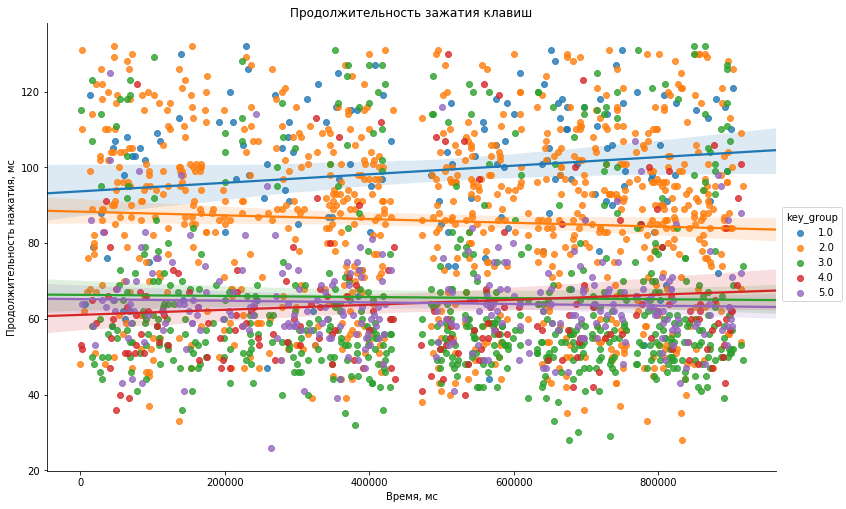

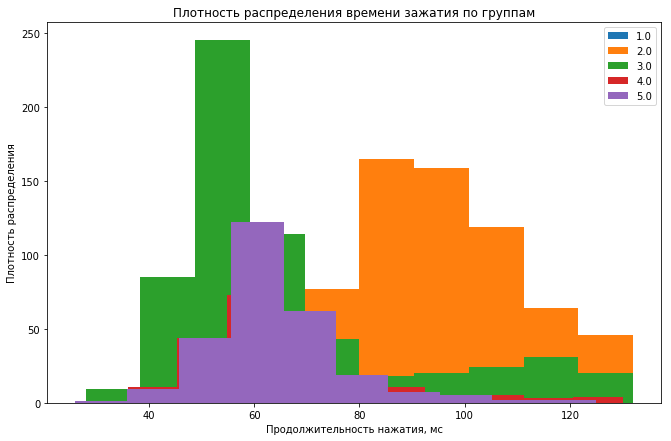

In [8]:
a.count_avg_duration()

### Подсчет среднего интервала перед нажатием клавиши

Под 0.950000-м квантилем 2068 значений.
Средняя продолжительность интервала между нажатиями:
 key_group
1.0    105.367347
2.0     90.000000
3.0     70.138535
4.0     65.465116
5.0     63.727642
Name: duration, dtype: float64
Медианная продолжительность интервала между нажатиями:
 key_group
1.0    124.0
2.0     99.0
3.0     92.0
4.0    150.0
5.0    167.5
Name: interval, dtype: float64


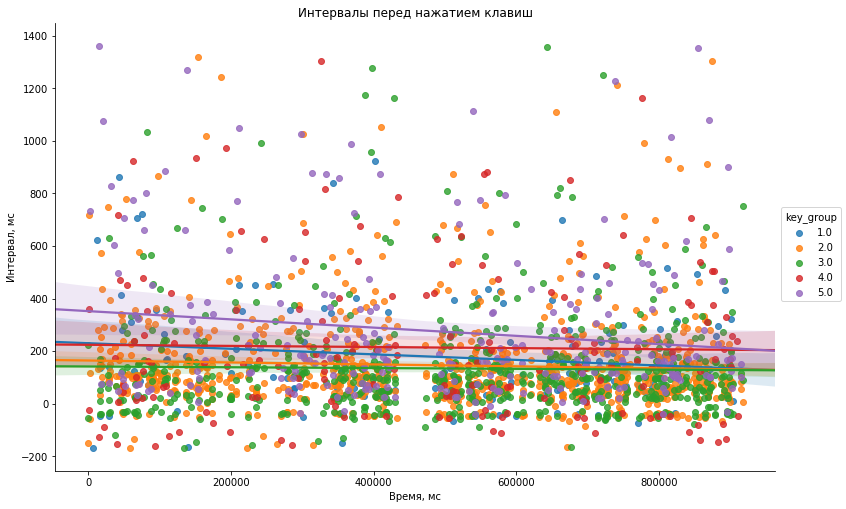

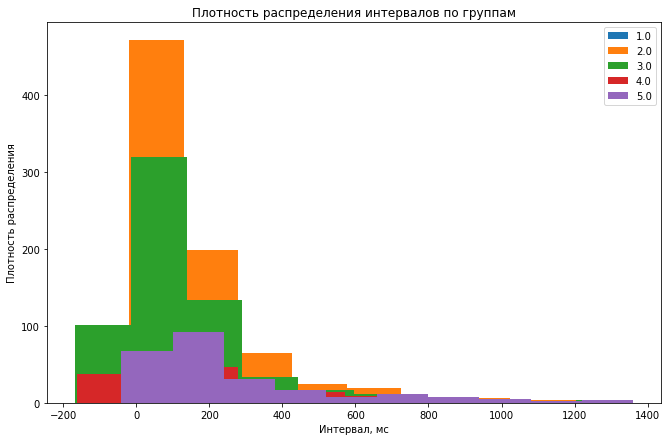

In [9]:
a.count_avg_interval()

### Подсчет количества опечаток

In [10]:
a.count_typos()

Относительное количество опечаток:
 key_group
1.0    0.017751
2.0    0.025386
3.0    0.015601
4.0    0.015957
5.0    0.029197
Name: key, dtype: float64
Слева/справа клавиатуры:  2.0
В центре/скраю клавиатуры:  5.5


### Способ переключения раскладки

In [11]:
a.count_lang_changing()

Переключение раскладки клавиатуры: alt


### Подсчет ошибок нажатия на shift

In [12]:
a.count_shift_mistakes()

Доля ошибочно нажатых шифтов:  0.04580152671755725
Средняя продолжительность ошибочно нажатого шифта:  106.33333333333333


### Временные расстояния внутри нажатия шифта

Медианный интервал от зажатия шифта до нажатия клавиши:
 key_group
1.0    245.5
2.0    194.5
3.0    203.0
4.0    117.0
Name: down_interval, dtype: float64
Медианный интервал от зажатия клавиши до отпуска шифта:
 key_group
1.0    226.0
2.0    216.5
3.0    151.5
4.0    107.0
5.0     38.0
Name: up_interval, dtype: float64
Средний интервал от зажатия шифта до нажатия клавиши:
 key_group
1.0    240.541667
2.0    193.700000
3.0    195.133333
4.0    133.000000
Name: down_interval, dtype: float64
Средний интервал от зажатия клавиши до отпуска шифта:
 key_group
1.0    221.880000
2.0    259.977273
3.0    167.562500
4.0    114.200000
5.0     38.000000
Name: up_interval, dtype: float64


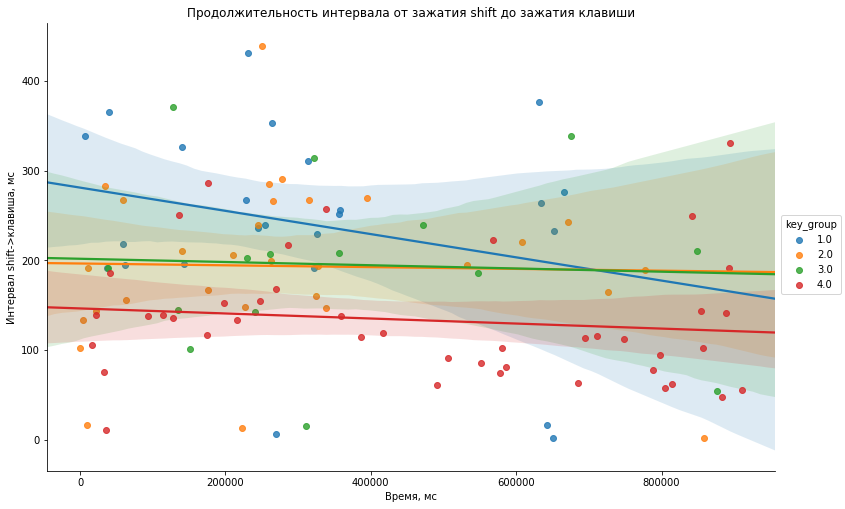

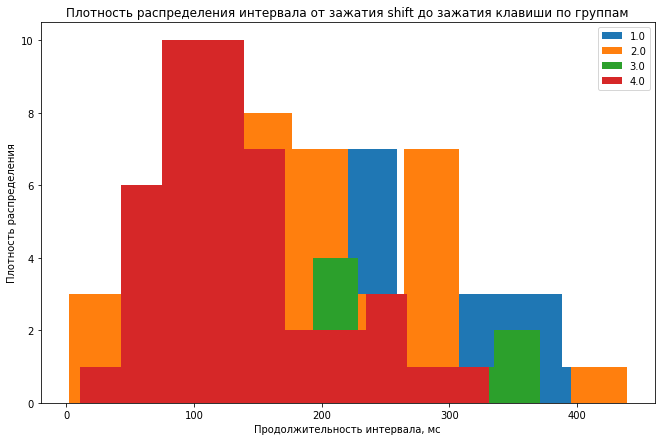

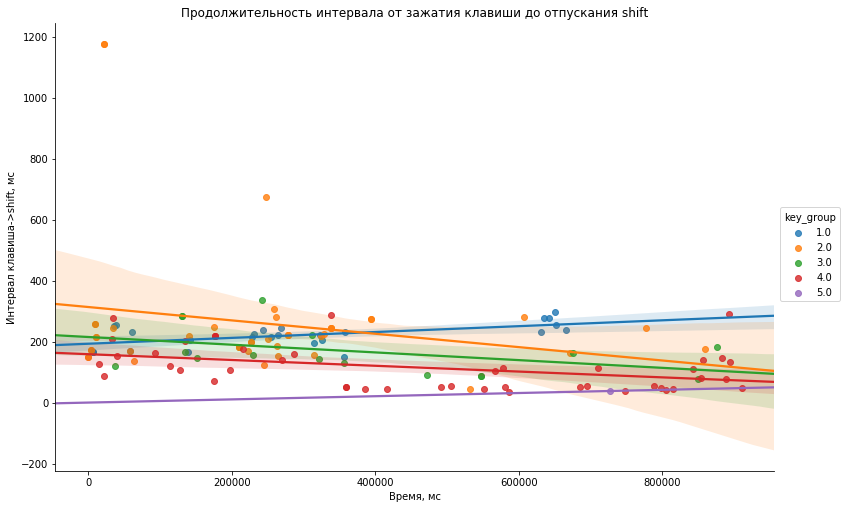

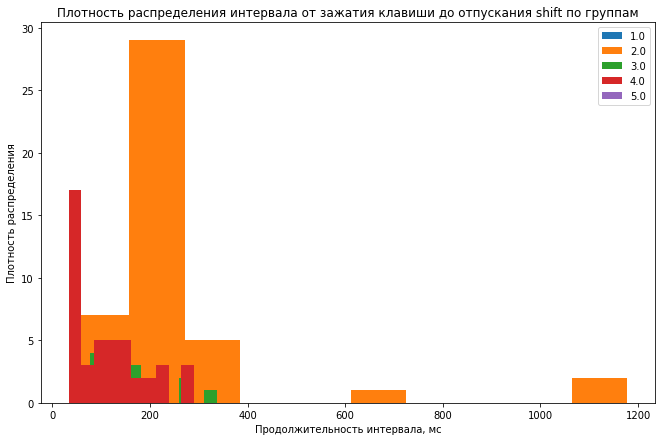

In [13]:
a.count_shift_distance()

### Подсчет количества слов, запоминаемых человеком за раз

Человек запоминает в среднем слов:  2.382608695652174


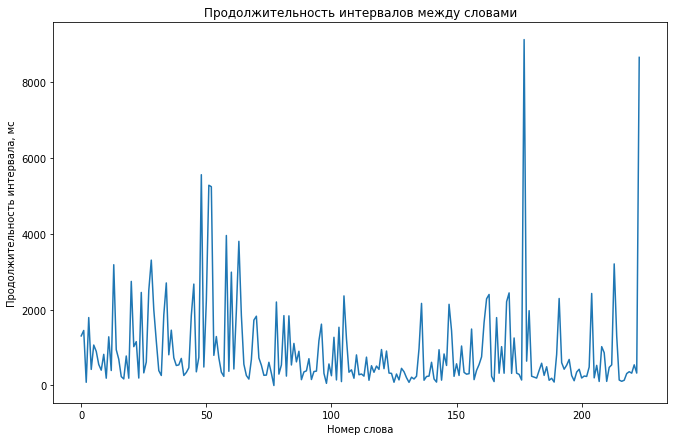

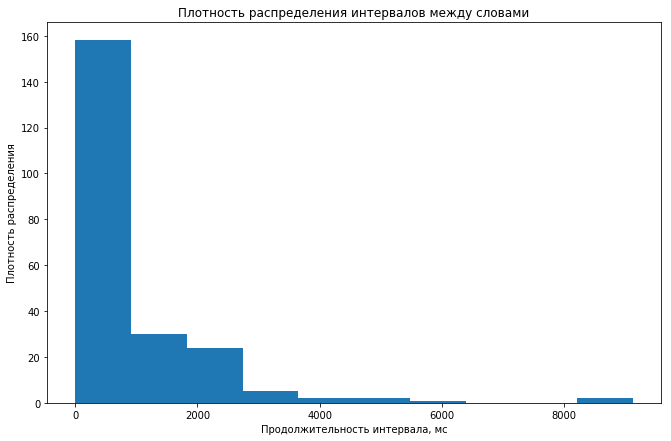

In [14]:
a.count_words_in_memory()

### Информация о выделенных признаках

In [15]:
a.info()

Средняя продолжительность удержания клавиш группы 1:		 99.08163265306122
Средняя продолжительность удержания клавиш группы 2:		 85.86283704572098
Средняя продолжительность удержания клавиш группы 3:		 65.58620689655173
Средняя продолжительность удержания клавиш группы 4:		 64.14673913043478
Средняя продолжительность удержания клавиш группы 5:		 64.16117216117216
Медиана продолжительности удержания клавиш группы 1:		 102.0
Медиана продолжительности удержания клавиш группы 2:		 88.0
Медиана продолжительности удержания клавиш группы 3:		 58.0
Медиана продолжительности удержания клавиш группы 4:		 59.5
Медиана продолжительности удержания клавиш группы 5:		 62.0

Средний интервал между нажатиями перед группой 1:		 105.36734693877551
Средний интервал между нажатиями перед группой 2:		 90.0
Средний интервал между нажатиями перед группой 3:		 70.13853503184713
Средний интервал между нажатиями перед группой 4:		 65.46511627906976
Средний интервал между нажатиями перед группой 5:		 63.7276422764

## Формирование таблицы признаков

Преобразуем все собранные сырые данные в признаки. Исходные данные - тексты, напечатанные 1500 либо 2500 нажатиями. Разделим их на куски по 600 нажатий.

In [61]:
%%time

X_dicts = []
ys = []

filenames = [fn for fn in ls() if 'raw' in fn]

file_i = 1
for fn in filenames:
    part_i = 1
    print("Файл: ", file_i, ":", fn, ", часть", end=" ")
    for dataset in Document(fn).split():
        print(part_i, end="..")
        doc = Document(data=dataset)
        doc.count_everything()
        X_dicts.append(doc.features)
        ys.append(file_i)
        part_i += 1
    file_i += 1
    print()
    
X = pd.DataFrame(X_dicts)
y = pd.Series(ys, name='class')
df = pd.concat([X, y], axis=1)

Файл:  1 : 2018-04-06T17:27:52.478725_raw.txt , часть 1..2..3..4..
Файл:  2 : 2017-12-24T09:18:34.596002_raw.txt , часть 1..2..
Файл:  3 : 2017-12-24T17:52:58.184451_raw.txt , часть 1..2..
Файл:  4 : 2017-12-23T13:27:16.123567_raw.txt , часть 1..2..
Файл:  5 : 2017-12-24T15:04:27.072468_raw.txt , часть 1..2..
Файл:  6 : 2018-03-15T21:20:46.566970_raw.txt , часть 1..2..3..4..
Файл:  7 : 2018-04-06T22:28:38.582672_raw.txt , часть 1..2..3..4..
Файл:  8 : 2017-12-24T21:59:02.046525_raw.txt , часть 1..2..
Файл:  9 : 2018-04-06T16:55:24.476917_raw.txt , часть 1..2..3..4..
Файл:  10 : 2018-03-27T21:03:41.074505_raw.txt , часть 1..2..3..4..
Файл:  11 : 2018-04-06T16:34:28.413211_raw.txt , часть 1..2..3..4..
Файл:  12 : 2018-04-06T17:13:06.334407_raw.txt , часть 1..2..3..4..
Файл:  13 : 2018-01-23T12:19:23.756080_raw.txt , часть 1..2..3..4..
Файл:  14 : 2018-04-06T16:50:53.966850_raw.txt , часть 1..2..3..4..
Файл:  15 : 2018-04-06T19:18:07.260757_raw.txt , часть 1..2..3..4..
Файл:  16 : 2018-04

Посмотрим на матрицу признаков.

In [93]:
df.head(12)

,avg_duration1,avg_duration2,avg_duration3,avg_duration4,avg_duration5,avg_interval1,avg_interval2,avg_interval3,avg_interval4,avg_interval5,...,shift_mistakes,typos_center_edge,typos_left_right,typos_per_presses1,typos_per_presses2,typos_per_presses3,typos_per_presses4,typos_per_presses5,words_in_memory,class
0,95.000000,88.577114,90.317647,89.513514,92.394366,101.958333,90.860000,95.966102,98.551724,92.869565,...,0.033333,1.000000,0.333333,0.020408,NaN,0.010929,0.024390,0.027778,0.500000,1
1,93.285714,88.643777,84.376623,92.266667,88.949153,94.186047,89.679654,90.683544,96.444444,91.387097,...,0.058824,inf,4.000000,NaN,0.016529,0.005952,NaN,NaN,0.430556,1
2,94.457143,94.237443,89.382857,89.459459,97.630769,100.315789,97.212670,96.067416,96.875000,100.312500,...,0.000000,inf,0.333333,NaN,0.004310,0.016129,NaN,0.029851,0.465278,1
3,95.761905,92.773585,86.397849,90.962963,89.614035,97.857143,97.381818,91.368984,87.666667,88.264151,...,0.000000,inf,0.600000,NaN,0.013216,0.025000,NaN,0.017544,0.329480,1
4,69.447368,64.367568,66.578616,70.615385,64.891892,69.447368,66.905263,66.647436,73.585366,67.159420,...,0.028571,1.500000,0.250000,0.026316,NaN,0.018750,0.022727,0.050633,0.647541,2
5,68.884615,65.256158,67.966292,67.088889,65.985714,75.906250,66.383495,69.111111,69.170732,64.693548,...,0.000000,5.000000,2.000000,NaN,0.018957,0.005435,0.020000,0.013889,0.500000,2
6,96.724138,83.461078,85.382857,88.366667,106.030769,103.062500,89.432584,88.017647,87.740000,110.246154,...,0.032258,13.000000,1.333333,NaN,0.043956,0.028090,0.016393,0.028571,0.752688,3
7,94.593750,84.656442,85.993151,89.255814,103.216216,98.235294,87.059880,91.352941,92.943662,108.546667,...,0.045455,5.500000,0.857143,0.027778,0.029762,0.037975,0.011364,NaN,1.025974,3
8,112.571429,102.615000,90.685185,92.630435,91.735849,119.823529,105.536232,90.574194,96.558140,92.096154,...,0.058824,3.333333,0.444444,NaN,0.018433,0.036810,0.061224,0.056604,0.473214,4
9,111.558824,99.398936,90.489933,91.745763,92.095238,117.307692,102.797927,90.881119,91.824561,92.338983,...,0.027778,2.000000,3.500000,0.073171,0.019512,0.013245,NaN,0.063492,0.600000,4


Преобразуем данные:

In [99]:
nan2zero_cols = [c for c in df.columns if 'typos' in c]
df[nan2zero_cols] = df[nan2zero_cols].fillna(value=0)

In [100]:
df = pd.get_dummies(df, columns=['lang'])

In [106]:
df.head()

,avg_duration1,avg_duration2,avg_duration3,avg_duration4,avg_duration5,avg_interval1,avg_interval2,avg_interval3,avg_interval4,avg_interval5,...,typos_per_presses2,typos_per_presses3,typos_per_presses4,typos_per_presses5,words_in_memory,class,lang_alt,lang_cmd,lang_ctrl_shift,lang_ctrl_space
0,95.000000,88.577114,90.317647,89.513514,92.394366,101.958333,90.860000,95.966102,98.551724,92.869565,...,0.000000,0.010929,0.024390,0.027778,0.500000,1,0,0,0,1
1,93.285714,88.643777,84.376623,92.266667,88.949153,94.186047,89.679654,90.683544,96.444444,91.387097,...,0.016529,0.005952,0.000000,0.000000,0.430556,1,0,0,0,1
2,94.457143,94.237443,89.382857,89.459459,97.630769,100.315789,97.212670,96.067416,96.875000,100.312500,...,0.004310,0.016129,0.000000,0.029851,0.465278,1,0,0,0,1
3,95.761905,92.773585,86.397849,90.962963,89.614035,97.857143,97.381818,91.368984,87.666667,88.264151,...,0.013216,0.025000,0.000000,0.017544,0.329480,1,0,0,0,1
4,69.447368,64.367568,66.578616,70.615385,64.891892,69.447368,66.905263,66.647436,73.585366,67.159420,...,0.000000,0.018750,0.022727,0.050633,0.647541,2,0,0,0,1


Сохраним данные.

In [107]:
with open("dataframe600.csv", 'w') as f:
    df.to_csv(f)

In [ ]:
df = pd.read_csv("dataframe600.csv")

In [103]:
y = df['class']
X = df.drop('class', axis='columns')

## Корреляционная матрица

Построим матрицу модуля корреляции для наглядности.

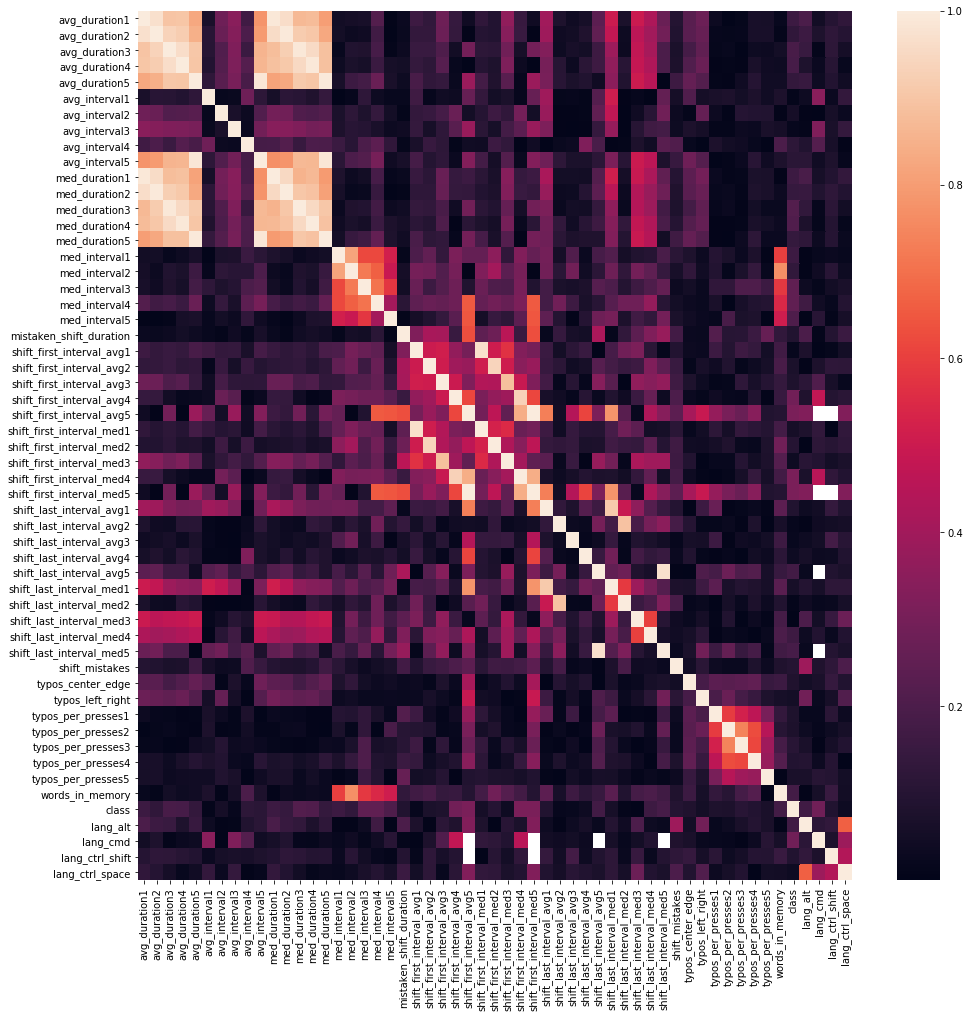

In [108]:
plt.figure(figsize=(16, 16))
sns.heatmap(abs(df.corr()))

## Распределения признаков

Посмотрим на взаимные зависимости признаков.

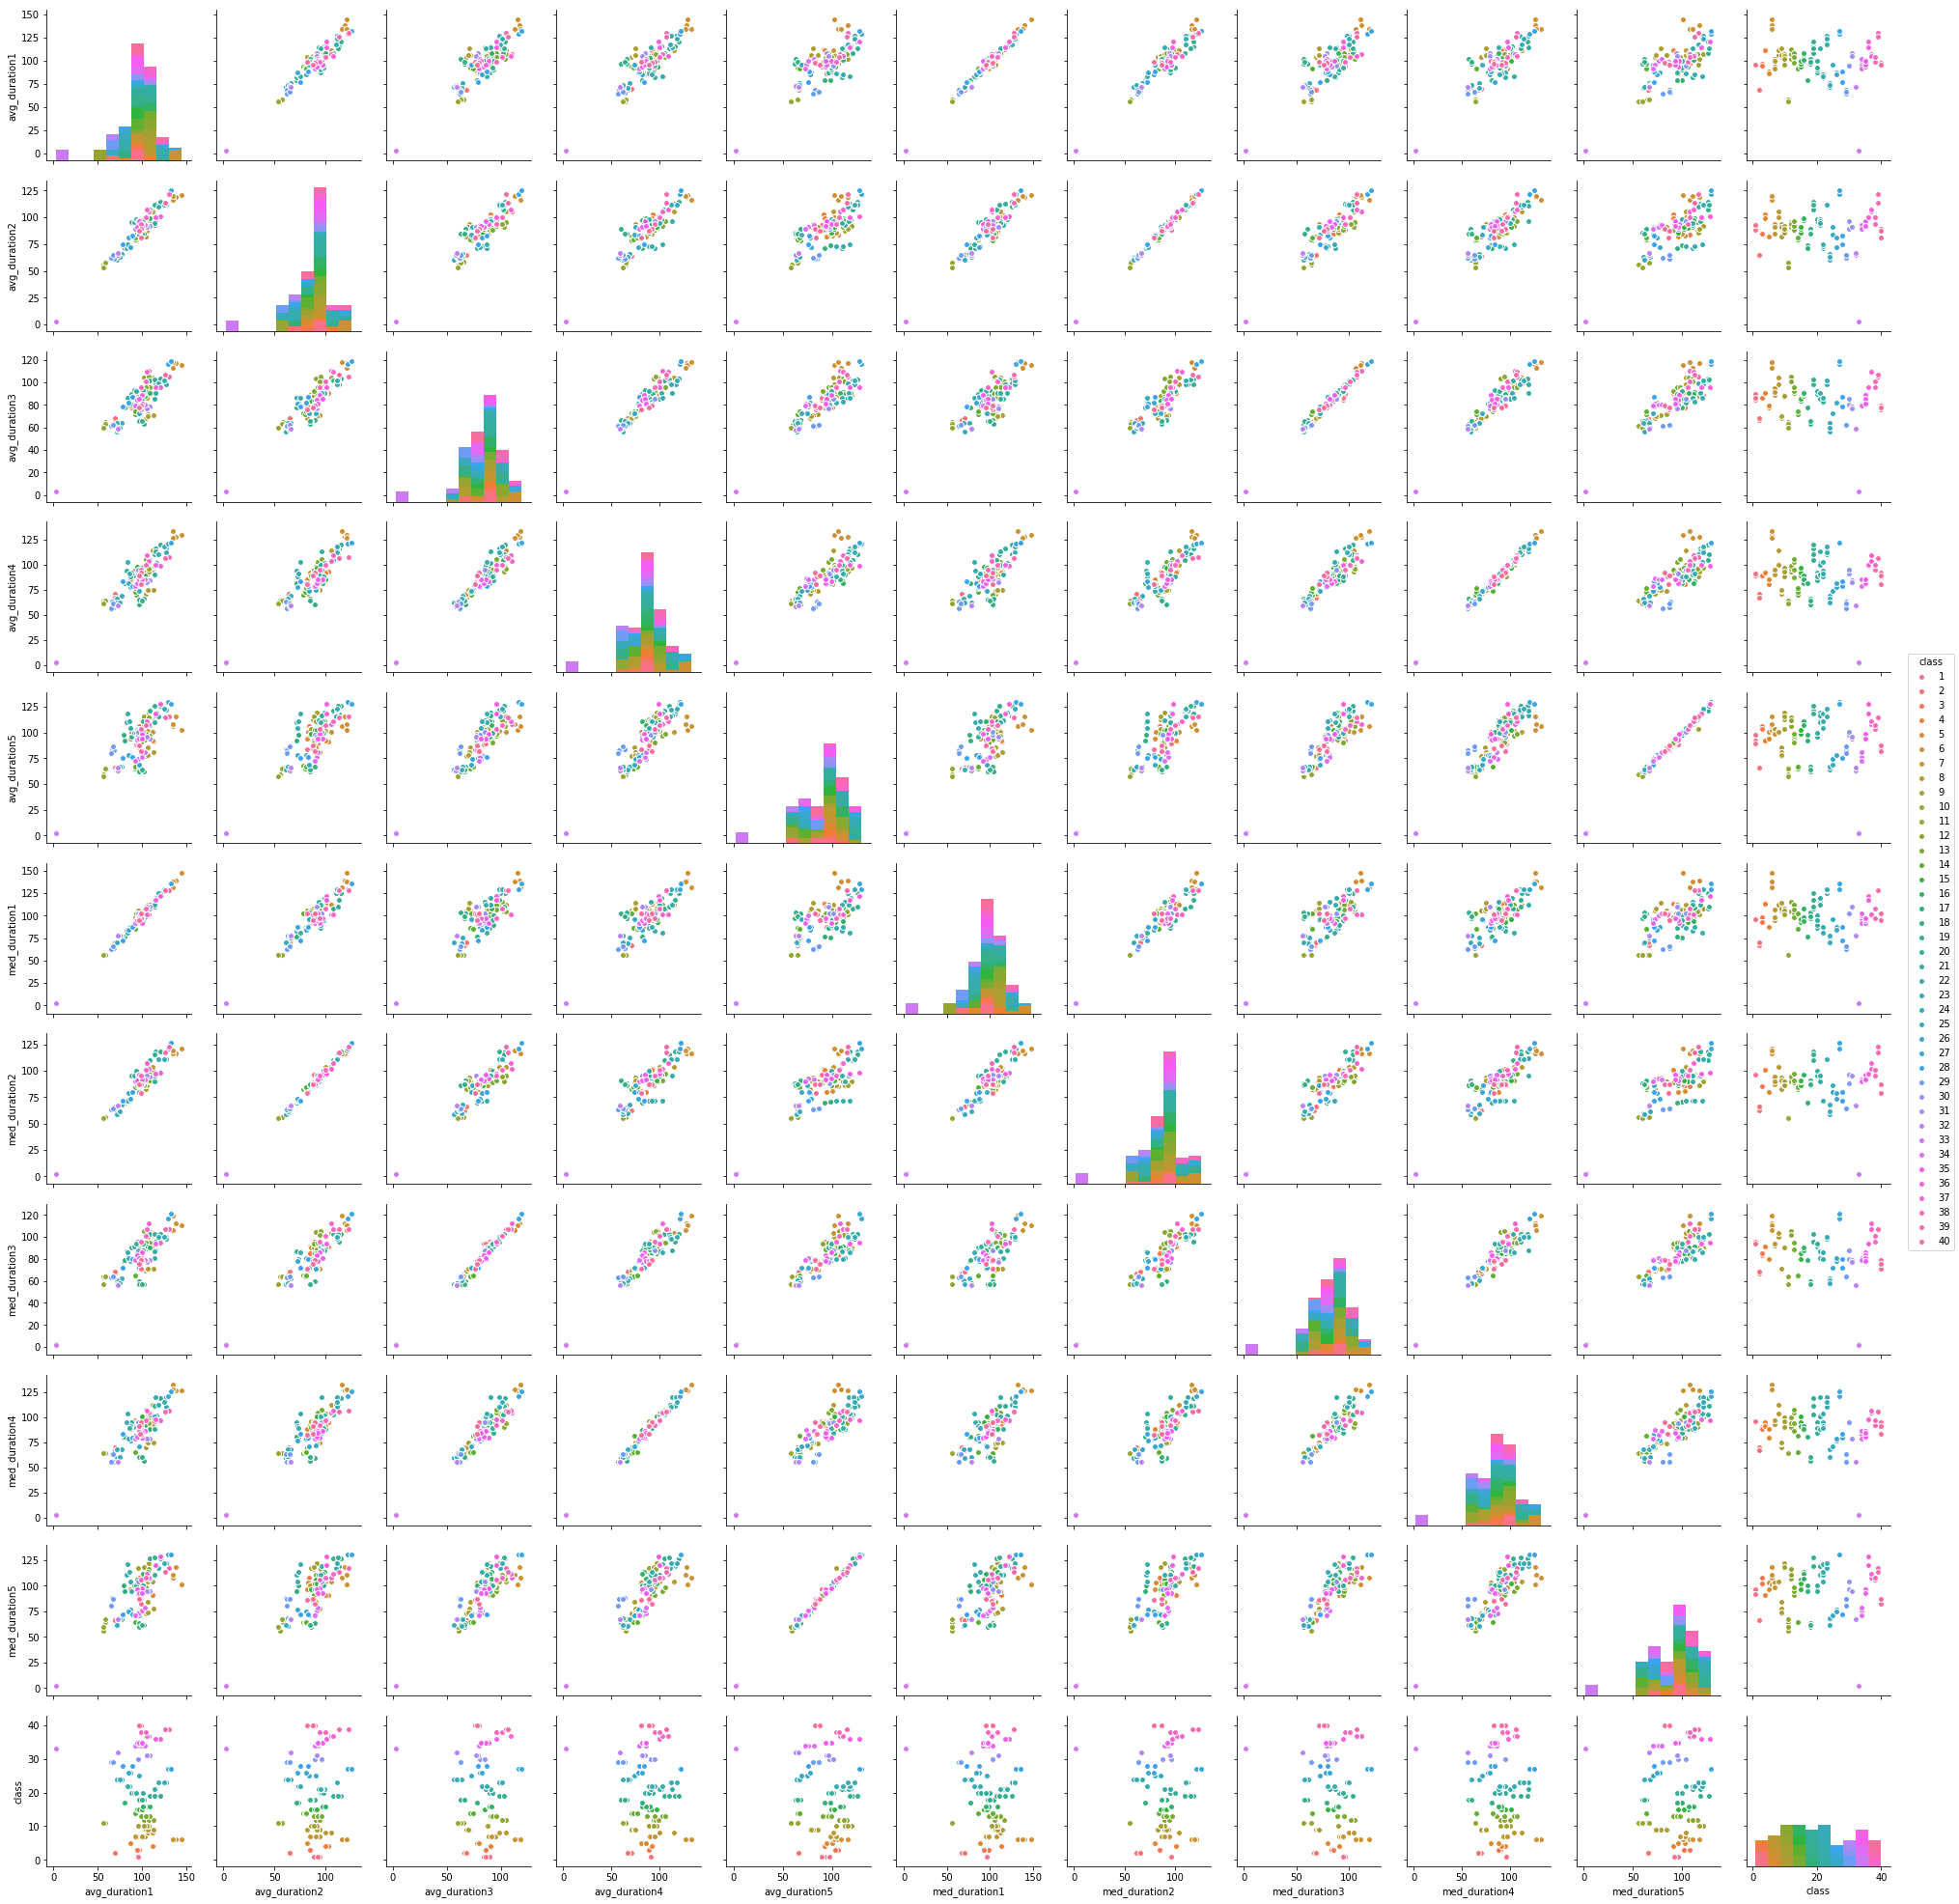

In [74]:
sns.pairplot(df[['%s_duration%d' % (s, i) for s in ['avg', 'med'] for i in range(1, 6)] + ['class']], hue='class')

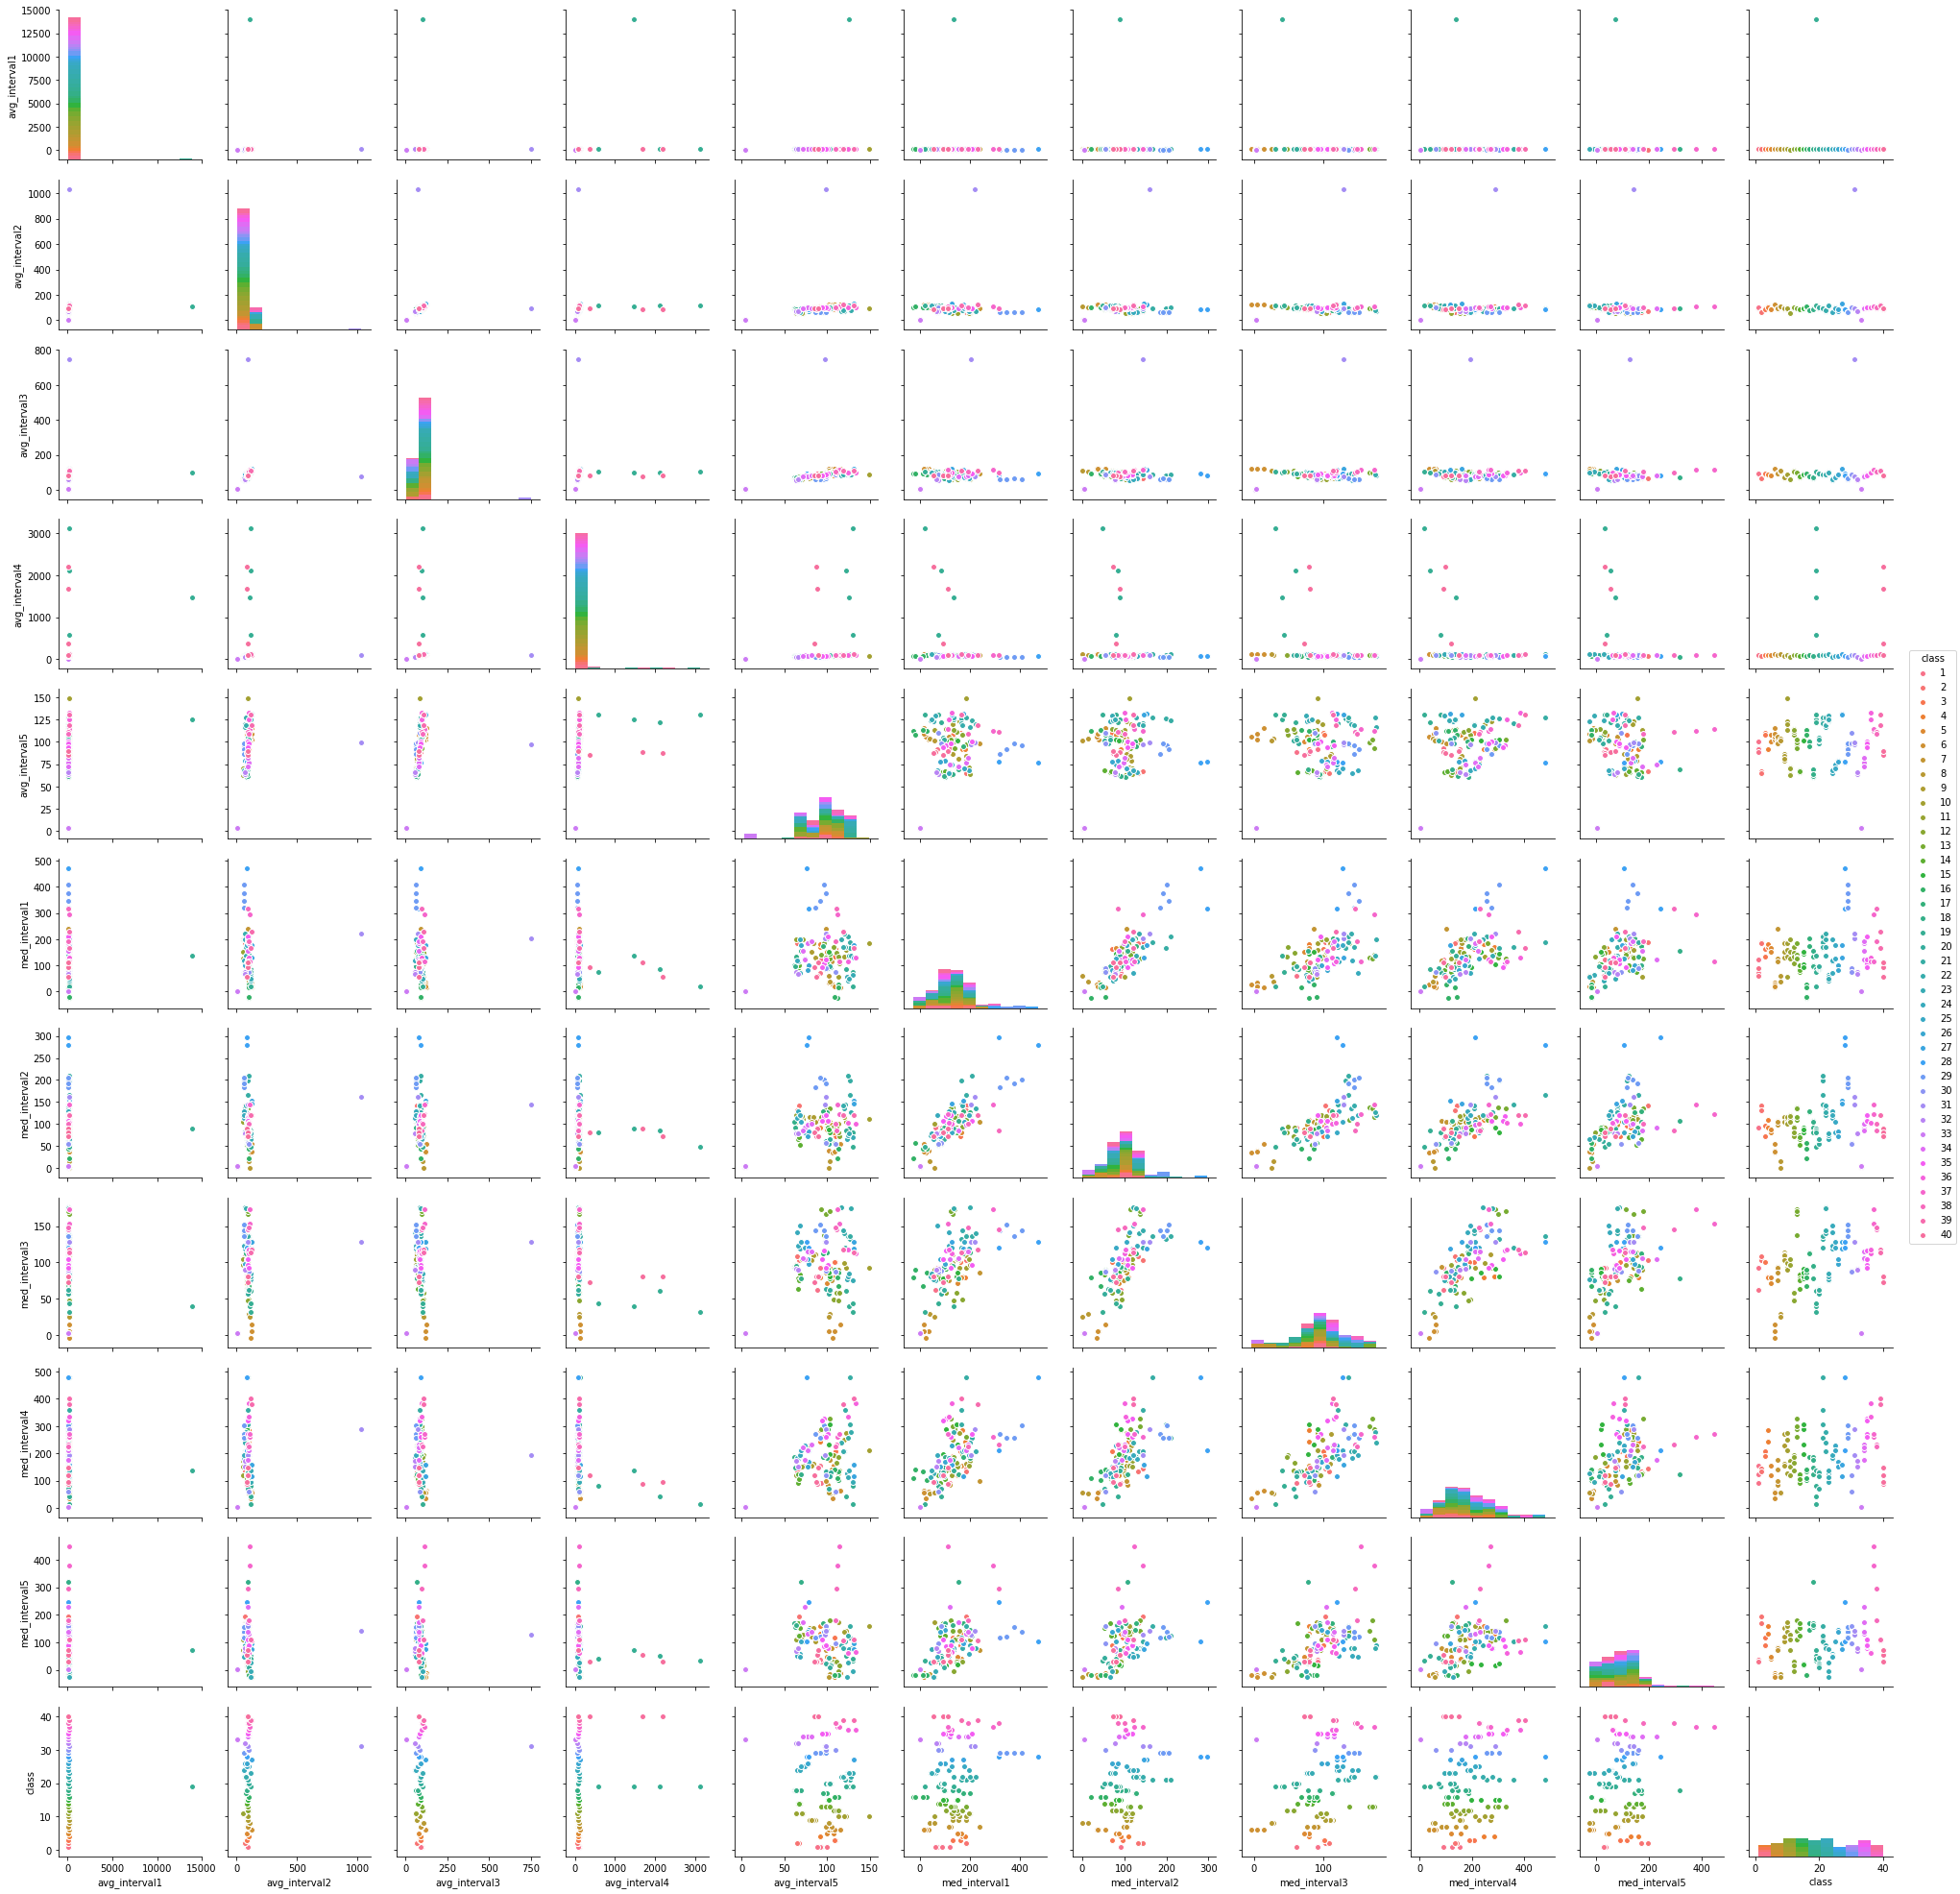

In [75]:
sns.pairplot(df[['%s_interval%d' % (s, i) for s in ['avg', 'med'] for i in range(1, 6)] + ['class']], hue='class')

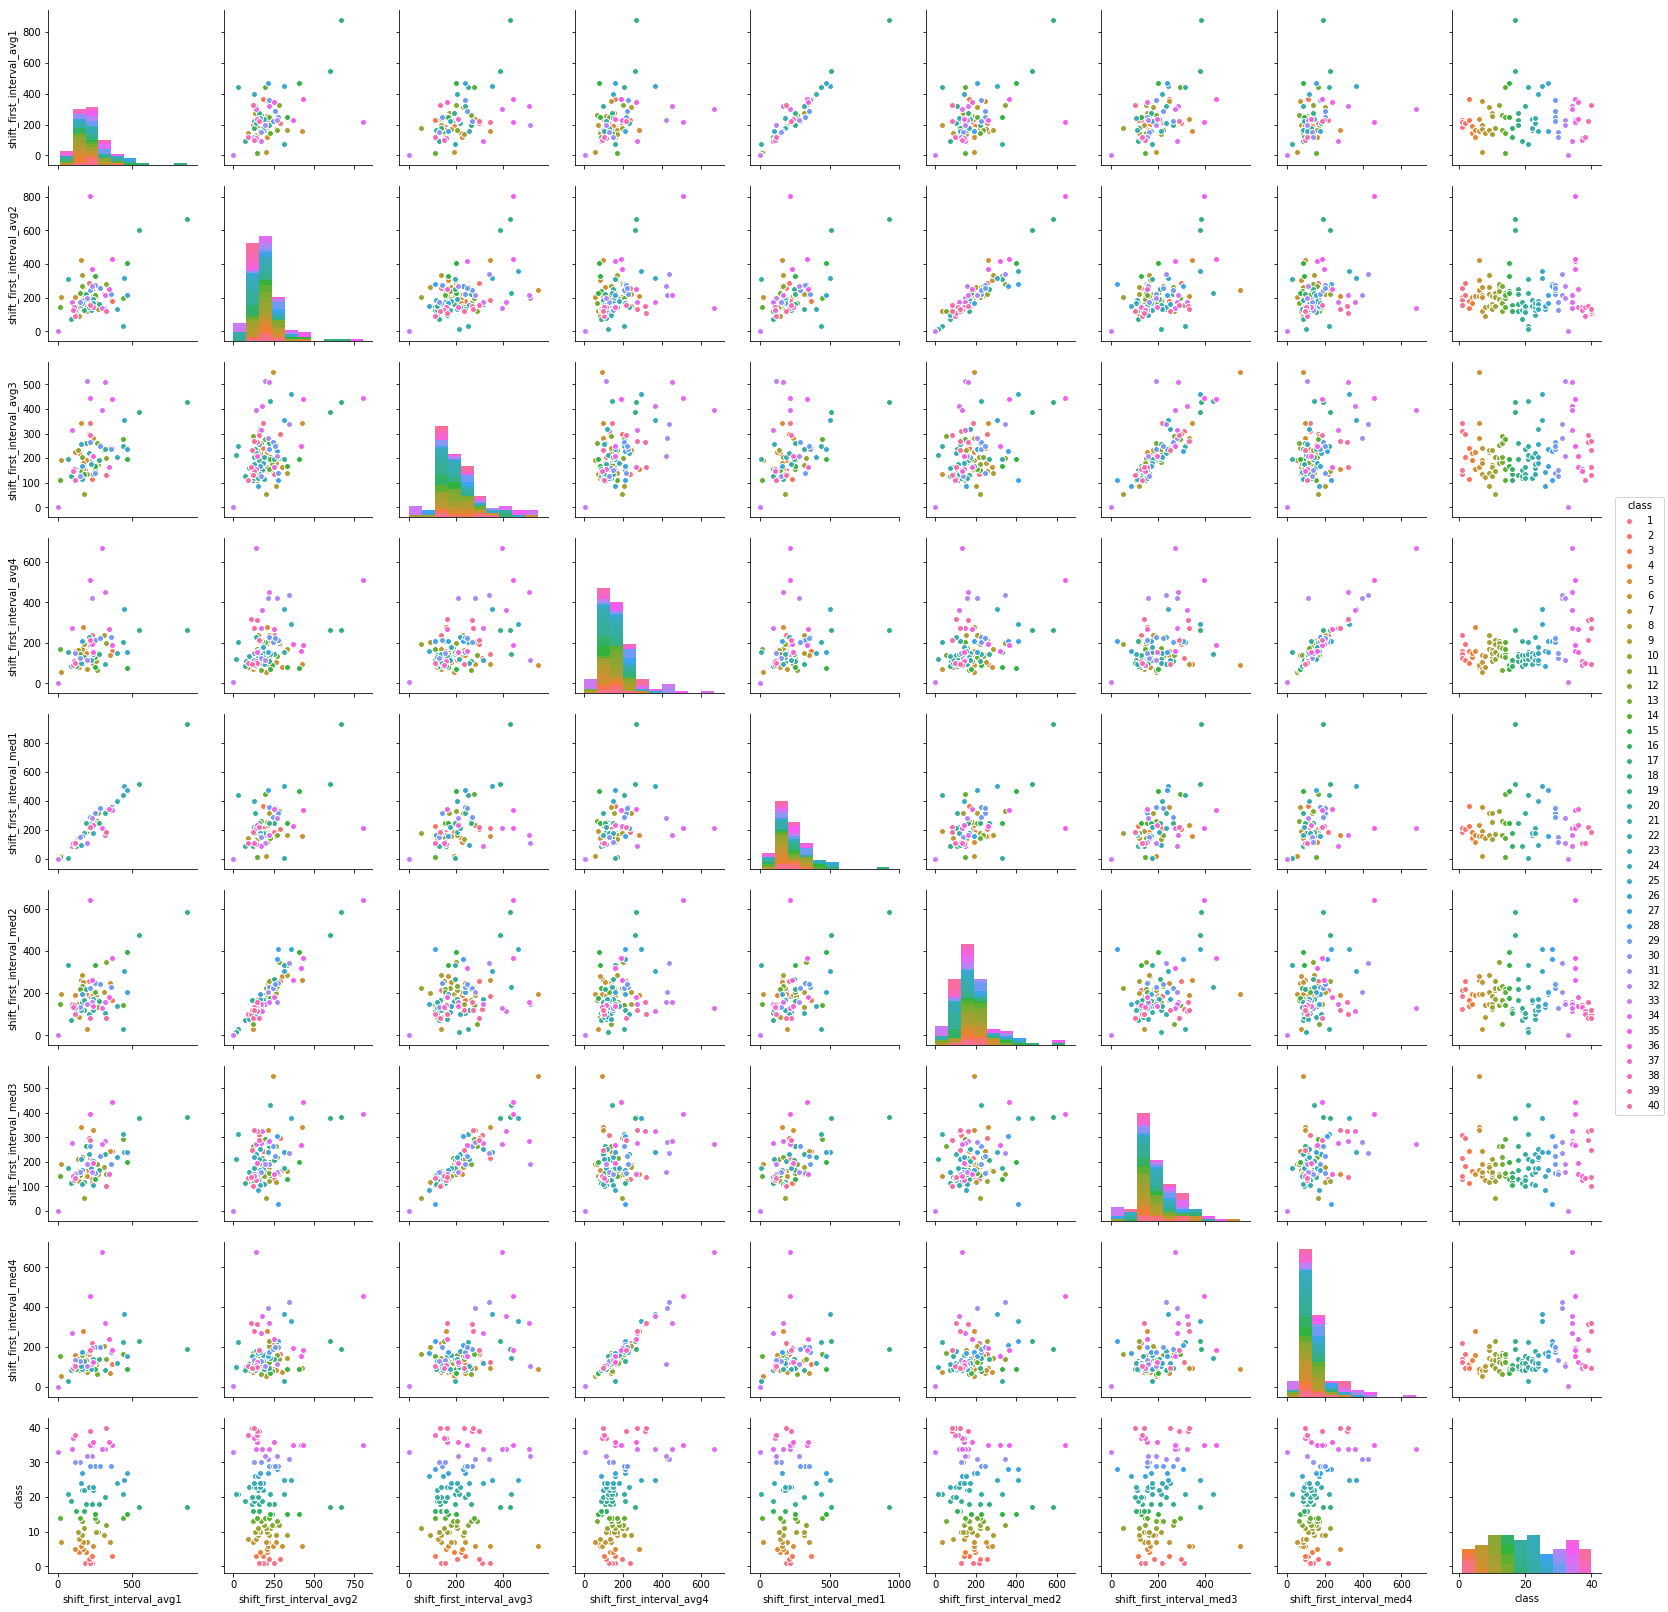

In [89]:
sns.pairplot(df[['shift_first_interval_%s%d' % (s, i) for s in ['avg', 'med'] for i in range(1, 5)] + ['class']],
             hue='class', dropna=True)

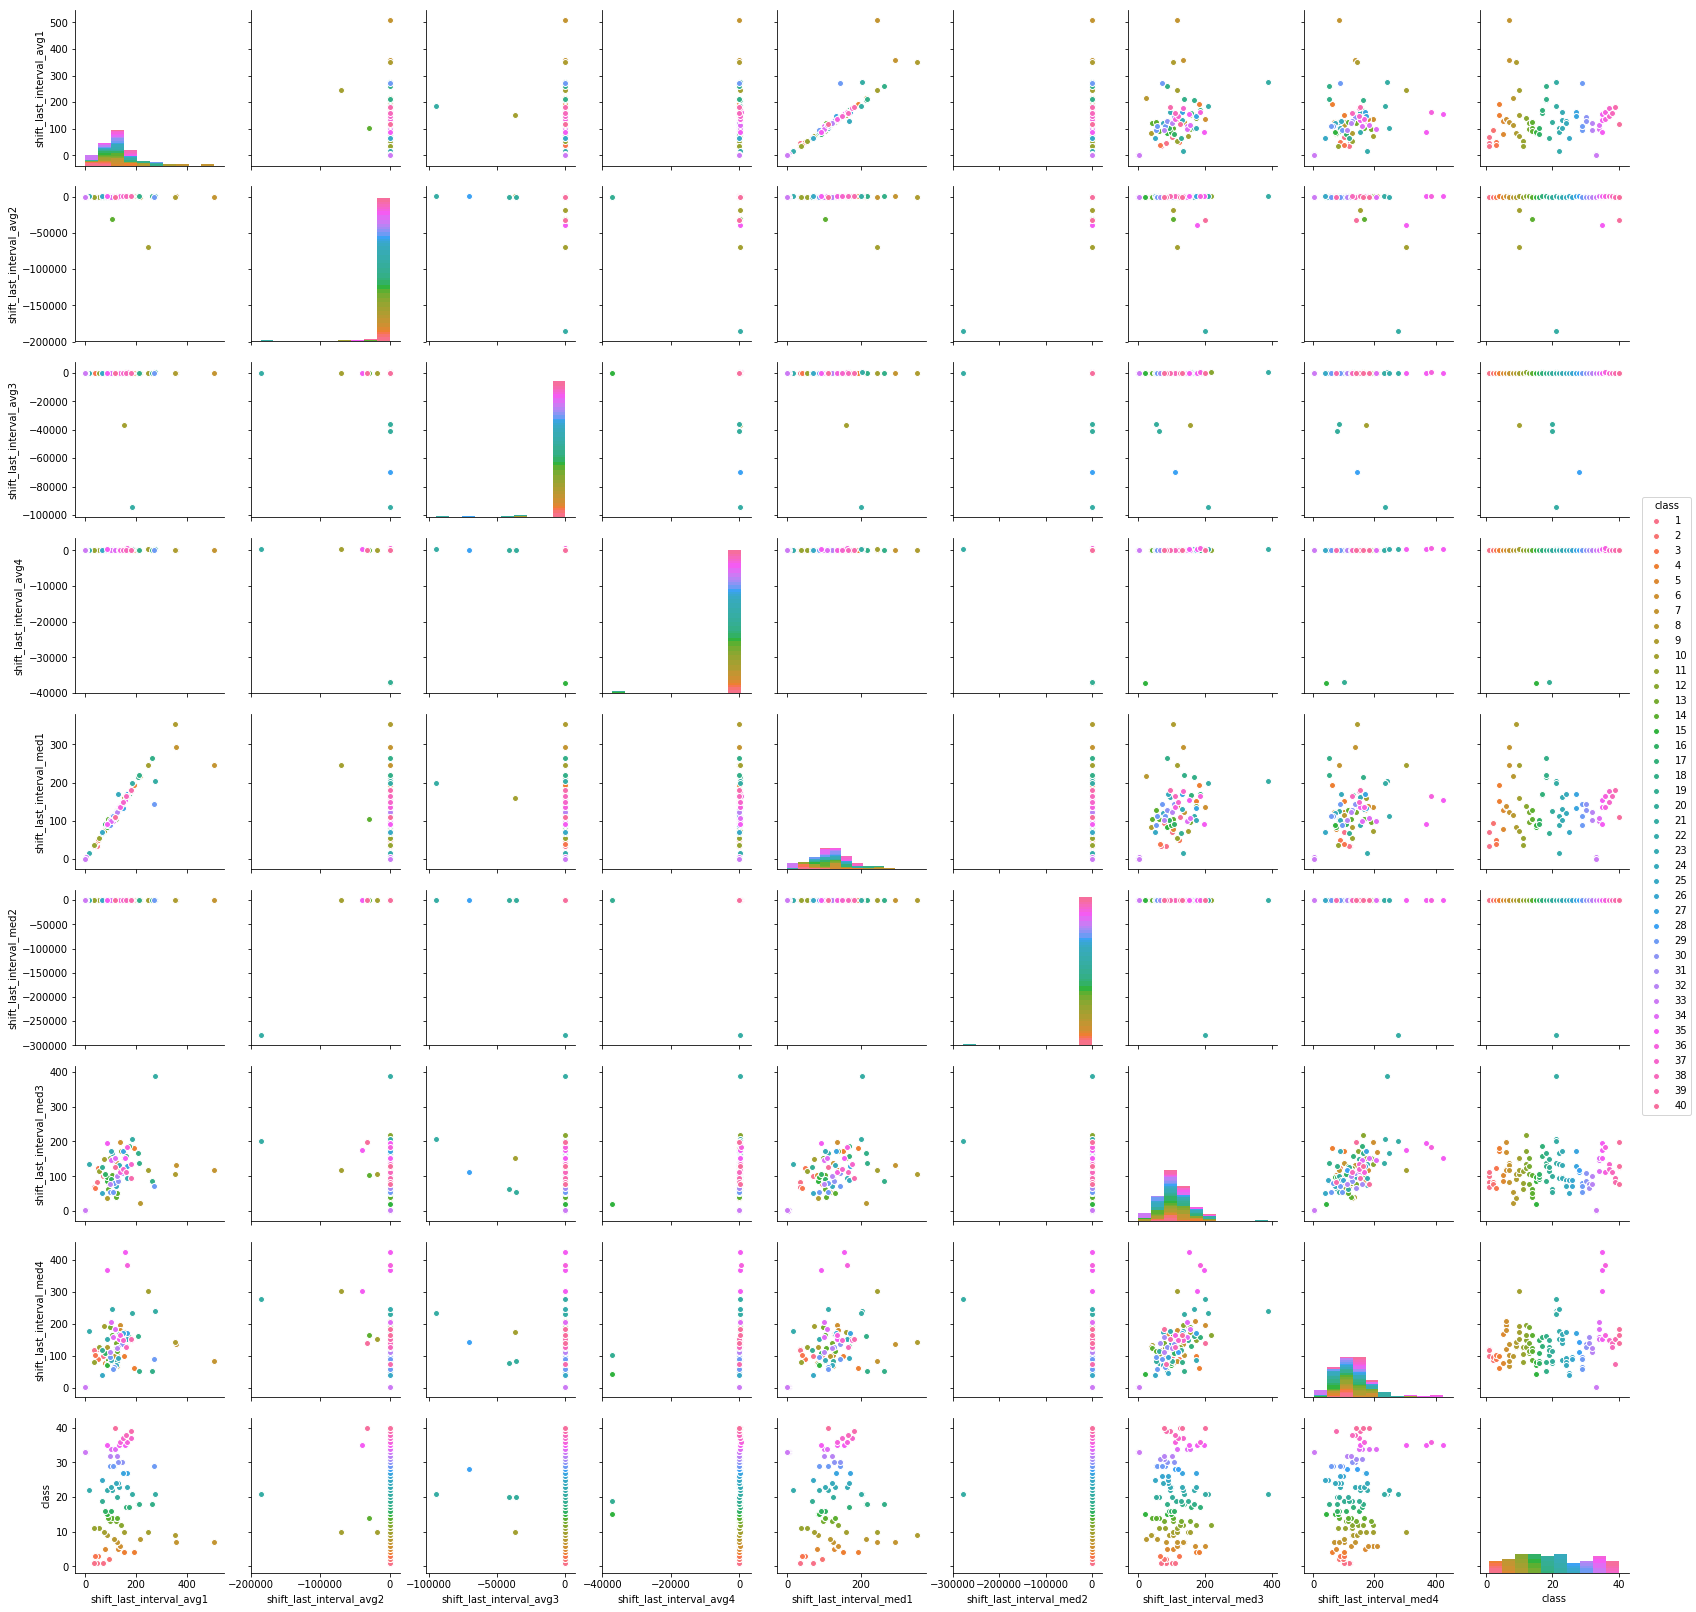

In [90]:
sns.pairplot(df[['shift_last_interval_%s%d' % (s, i) for s in ['avg', 'med'] for i in range(1, 5)] + ['class']], hue='class')

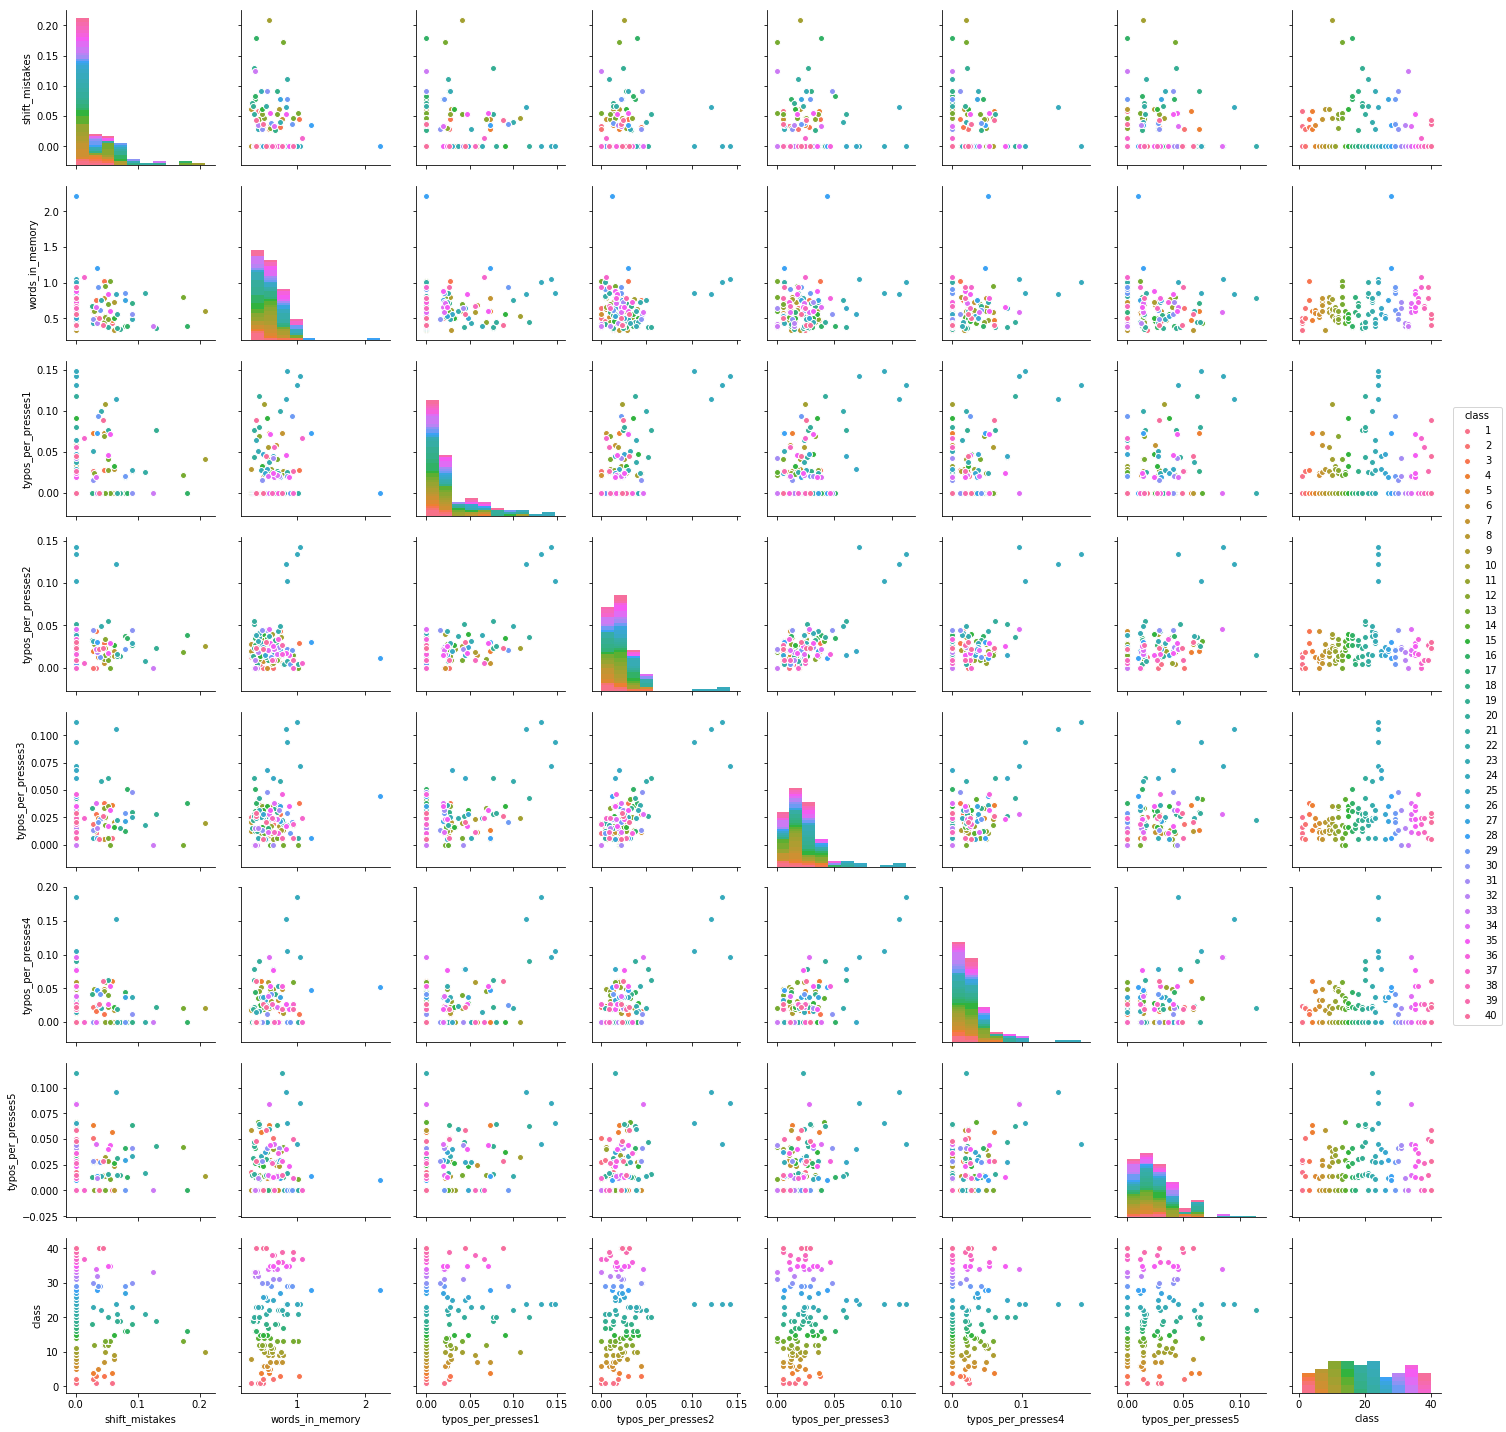

In [120]:
sns.pairplot(df[['shift_mistakes', 'words_in_memory'] + ['typos_per_presses%d' % i for i in range(1, 6)] + ['class']],
             hue='class')

Корреляция величин, представленных средними и медианными значениями, высока, но удалять их не будем, чтобы посмотреть, какие из этих величин внесут лучший вклад в модель.

## Избыточность данных

Проанализируем данные методом главных компонент.

[]

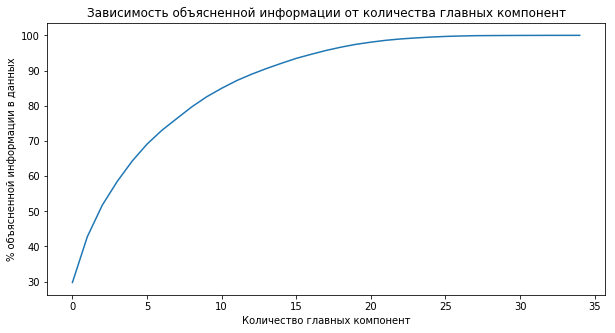

In [152]:
{c: all(np.isfinite(X[c]))for c in X.columns}

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[[c for c in X.columns if all(np.isfinite(X[c]))]])

pca = PCA(random_state=17)
pca_result = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('Количество главных компонент')
plt.ylabel('% oбъясненной информации в данных')
plt.title('Зависимость объясненной информации от количества главных компонент')
plt.plot()

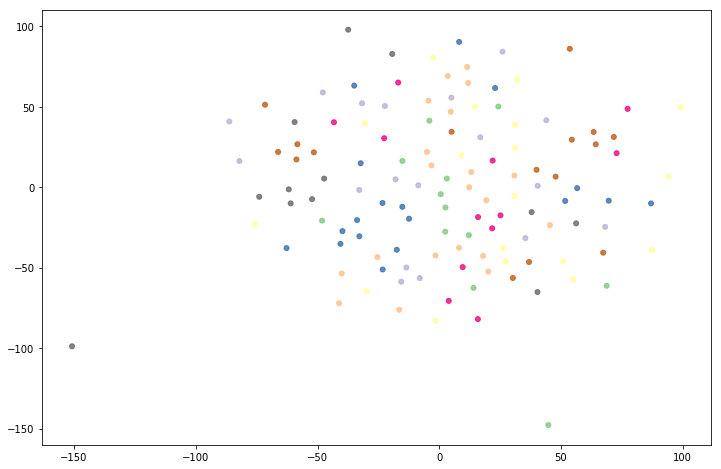

CPU times: user 2.69 s, sys: 987 ms, total: 3.68 s
Wall time: 2.66 s


In [151]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(random_state=17)
tsne_representation = tsne.fit_transform(X_scaled, y=y)

plt.figure(figsize=(12,8))
plt.scatter(tsne_representation[:,0], tsne_representation[:,1], c=y, s=25, alpha=.8, cmap='Accent')
plt.show()

Видно, что некоторые классы хорошо выделяются, а некоторые разбросаны.

## Подготовка данных для моделей

Разобьем данные на тренировочную и тестовую выборки.

In [202]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[[c for c in X.columns if 'avg' not in c and all(np.isfinite(X[c]))]], y,
                                                    stratify=y, test_size=0.32, random_state=17)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((85, 23), (41, 23), (85,), (41,))

## Решающее дерево

In [255]:
from sklearn.tree import DecisionTreeClassifier


tree = DecisionTreeClassifier(max_depth=25)
tree.fit(X_train, y_train)

prediction = tree.predict(X_test)

accuracy = tree.score(X_test, y_test)
accuracy

0.5365853658536586

In [ ]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

export_graphviz(tree, feature_names=X_train.columns, out_file='tree.dot', filled=True)
graph = pydotplus.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')
Image(filename='tree.png')

In [242]:
from sklearn.multiclass import OneVsRestClassifier

onevsall = OneVsRestClassifier(DecisionTreeClassifier(max_depth=175))
onevsall.fit(X_train, y_train).score(X_test, y_test)

0.34146341463414637

In [243]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=200)
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

/home/ivan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6341463414634146

In [244]:
onevsallxgb = OneVsRestClassifier(XGBClassifier(n_estimators=300))
onevsallxgb.fit(X_train, y_train).score(X_test, y_test)

0.5365853658536586

In [249]:
from sklearn.ensemble import RandomForestClassifier

onevsallfrst = OneVsRestClassifier(RandomForestClassifier(max_depth=100, n_estimators=200, n_jobs=-1))
onevsallfrst.fit(X_train, y_train).score(X_test, y_test)

0.7804878048780488

In [254]:
from sklearn.neighbors import KNeighborsClassifier

onevsallfrst = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=1, n_jobs=-1))
onevsallfrst.fit(X_train, y_train).score(X_test, y_test)

0.7560975609756098

In [215]:
onevsall.predict(X_test), y_test

(array([ 9, 37, 38, 32,  2,  7, 37, 39, 27, 20, 40, 33,  1, 12,  6, 35, 35,
        40, 40, 22, 17, 40,  9, 40, 40, 40, 40, 40, 14, 11, 40, 20, 36, 40,
        40,  5, 25, 40, 40, 24, 13]), 122    40
 117    37
 118    38
 101    32
 91     28
 94     29
 56     18
 114    36
 89     27
 9       4
 20      8
 103    33
 18      7
 35     12
 13      6
 23      9
 46     15
 2       1
 68     21
 75     22
 112    35
 29     10
 5       2
 97     30
 99     31
 60     19
 7       3
 87     26
 45     14
 32     11
 73     22
 65     20
 120    39
 76     23
 107    34
 10      5
 84     25
 55     17
 52     16
 81     24
 41     13
 Name: class, dtype: int64)